In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.word_embedding import WordEmbedding
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.model_utils import get_best_weights_file_from, get_loss_model_weights_path
from lib.model.metrics import rmse
from lib.model.search.search_factory import SearchFactory
from lib.model.search.beam_search_k_finder import BeamSearchKFinder, random_samples

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import show_sample, display_table
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from lib.callback.clr_callback               import CyclicLR
from keras.callbacks                         import ReduceLROnPlateau

from lib.model.inspector.prediction_inspector_factory import PredictionInspectorFactory

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
W0706 00:29:37.174207 140047639689024 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Image captioning model

## Common parameters

What dataset we are going to use?

In [10]:
dataset_name='8k' # Flickr8k
# dataset_name='30k' # Flickr30k

Each line of dataset contain an image_path + separator + a descrption. Next regex are used to separate these:

In [11]:
line_separator = { 
    '8k': r'#[0-9]', # Flickr8k
    '30k': r'\| [0-9]\|' # Flickr30k
}

Dataset data file & iamges paths:

In [12]:
dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'

What word embedding we are going to use?

Select word embedding. The embedding word vector size depend of embedding file, in this case is 300 or 1024.

In [13]:
# ELMO
word_embeding_name = 'elmo' 
word_embedding_path = f'./dataset/embedding/elmo/'
word_embedding_vector_dim = 1024

# GLOVE
# word_embeding_name = 'glove'
# word_embedding_vector_dim = 300
# file = 'glove.6B.300d.txt'
# file = 'glove.840B.300d.txt'
# word_embedding_path = f'./dataset/embedding/glove/{file}'

Path's where we save images and words embeddings:

In [14]:
image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{word_embeding_name}.pkl'

Path where save model weights:

In [15]:
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{loss:.4f}_val_loss_{val_loss:.4f}__rmse_{rmse:.4f}__val_rmse_{val_rmse:.4f}.h5'

Sample group files:

In [16]:
prefix = '_model_c'

train_samples_file =  f'{dataset_path}/train_samples{prefix}'
val_samples_file = f'{dataset_path}/val_samples{prefix}'
test_samples_file = f'{dataset_path}/test_samples{prefix}'

## Data preparation

Load dataset:

In [17]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [18]:
dataset.max_desc_len()

34

Separate sample in three groups:
* Train samples
* Validatiion samples
* Test sasmples

In [19]:
val_size=0.14
test_size=0.115

In [20]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=val_size, shuffle=True)
val_samples, test_samples = train_test_split(remain_samples, test_size=test_size, shuffle=True)

In [21]:
print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 6958, Val: 1002, Test: 131


Save sample groups. This step is very important, given that once model was train always must evaluate with same test samples selected before model train. 

In [22]:
if not os.path.isfile(train_samples_file):
    save_obj(train_samples_file, train_samples)
    print(f'Save sample to {train_samples_file}')
else:
    train_samples = load_obj(train_samples_file)
    print(f'Load sample from {train_samples_file}')

if not os.path.isfile(val_samples_file):
    save_obj(val_samples_file, val_samples)
    print(f'Save sample to {val_samples_file}')
else:
    val_samples = load_obj(val_samples_file)
    print(f'Load sample from {val_samples_file}')
    
if not os.path.isfile(test_samples_file):
    save_obj(test_samples_file, test_samples)
    print(f'Save sample to {test_samples_file}')
else:
    test_samples = load_obj(test_samples_file)
    print(f'Load sample from {test_samples_file}')

Load sample from ./dataset/8k/train_samples_model_c
Load sample from ./dataset/8k/val_samples_model_c
Load sample from ./dataset/8k/test_samples_model_c


In [23]:
print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 6958, Val: 1002, Test: 131


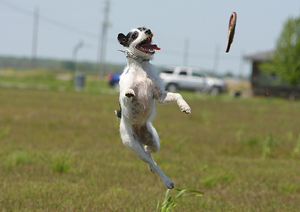

Description
dog in field jump for frisbee
small black and white jump to catch something in its mouth
small white dog with his tongue out be jump up to catch toy
white dog be jump up in the air to catch frisbee
white dog with dark marking jump to catch an object


In [24]:
show_sample(train_samples[0])

### Generate images embedding 
This step evaluate all dataset images in **InceptionV3 model** with **imagenet weights** and get output from last convolutional layer. 
The idea is precalculate an "image embedding" to minimize the **image captionining model** train times. Save results to a file given that this process can take a long time.

In [25]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)
else:
    image_features = load_obj(image_features_path)

print(f'Image embedding size: {len(image_features)} == Dataset size: {len(dataset.samples())}')
print(f'\nSample:\n- Image: {image_features[0][0]}\n- Embedding vector: {image_features[0][1]}')
image_features = dict(image_features)

Image embedding size: 8091 == Dataset size: 8091

Sample:
- Image: ./dataset/8k/images/1305564994_00513f9a5b.jpg
- Embedding vector: [ 0.06508786  0.03218709  0.0237698  ...,  0.3836866   0.19910577
  0.23510413]


### Generate words embedding

Select words vocabulary:

In [26]:
word_min_occurs=10

vocabulary = dataset.words_set(min_occurs=word_min_occurs)

# ------------------------------------------------------------------------------------
# READ IMPORTANT NOTE!
# ------------------------------------------------------------------------------------
# => Add "+ 1" to vocabulary_size because words are indexed from 1 instead of zero.
# ------------------------------------------------------------------------------------
vocabulary_size = len(vocabulary) + 1

complete_vocabulary_size = len(dataset.words_set())

In [27]:
print(f'Words(occurs>={word_min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1595/6689


Build **world to index*** and **index to world** dictionaries:

In [28]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

Build world embedding matrix: Save matrix to a file given that this process can take a long time.

In [29]:
print(f'Word embedding: {word_embeding_name}, Path: {word_embedding_path}, VectorDim:: {word_embedding_vector_dim}')

Word embedding: elmo, Path: ./dataset/embedding/elmo/, VectorDim:: 1024


In [30]:
if not os.path.isfile(descrption_embedding_path):
    embedding = WordEmbedding.create(
        word_embeding_name,
        path=word_embedding_path,
        vector_dim=word_embedding_vector_dim
    )
    embedding_matrix =  embedding.encode(word_to_index, vocabulary_size)
    save_obj(descrption_embedding_path, embedding_matrix)
else:
    embedding_matrix = load_obj(descrption_embedding_path)

print(f'Word embedding: {embedding_matrix.shape}')

Word embedding: (1595, 1024)


**Note**: In best case word embedding size is equal to vocabulary size. 

## Model build & train

In [31]:
def dense(network, units, activation, name='', leaky_relu_alpha=0.3):
    if 'leaky_relu' == activation:
        network = Dense(name=name, units=units)(network)
        return LeakyReLU(alpha=leaky_relu_alpha)(network)        

    return Dense(name=name, units=units, activation=activation)(network)

def build_model(
    vocabulary_size, 
    word_embedding_vector_dim, 
    embedding_matrix, 
    optimizer, 
    activation='relu', 
    units=512, 
    dropout=0.2, 
    leaky_relu_alpha=0.3,
    embedding_trainable=False
):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))
    img_branch = Dropout(dropout)(img_feat_input)
    img_branch = dense(img_branch, units, activation, name='Image_Dense', leaky_relu_alpha=leaky_relu_alpha)    

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, word_embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(dropout)(seq_branch)
    seq_branch = LSTM(units)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = dense(decoder, units, activation, name='Decoder_Dense', leaky_relu_alpha=leaky_relu_alpha)
 
    outputs = dense(decoder, units=vocabulary_size, activation='softmax', name="Words_Distribution")

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)


    embedding_layer = list(filter(lambda it: it.name.startswith("embedding"), model.layers))[0]
    if not embedding_layer is None:
        print(f'{embedding_layer.name}: Set trainable=false & load wordl embedding as layer weights')
        embedding_layer.set_weights([embedding_matrix])
        embedding_layer.trainable = embedding_trainable

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

### Train model

Define hiperparameters uses to train each train step:

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

class AdamOptimizer:
    def __init__(self, lr): 
        self.lr = lr
        self.optimizer = Adam(lr=lr)
    def append_to(self, callbacks): return callbacks
    def __str__(self):
        return f'''
            - {self.optimizer.__class__.__name__} optimizer:
                - lr:_____________ {self.lr}
            '''
    def graph(self):
        pass
    

class CRLOptimizer:
    def __init__(self, optimizer, clr, cycles, samples_size, batch_size):
            self.optimizer     = optimizer
            self.clr           = clr
            self.cycles        = cycles
            self.batch_size    = batch_size
            batchs_per_epoch   = samples_size / batch_size
            self.clr.step_size = math.floor((batchs_per_epoch / cycles)*0.5)
    
    def append_to(self, callbacks): return callbacks + [self.clr]
    def __str__(self):
        return f'''
            CLR + {self.optimizer.__class__.__name__} optimizer:
            - mode_________________{self.clr.mode}
            - cycles_______________{self.cycles}
            - batch_size___________{self.batch_size}
            - step_size____________{self.clr.step_size}
            - base_lr______________{self.clr.base_lr}
            - max_lr_______________{self.clr.max_lr}
            - gamma________________{self.clr.gamma}
            '''
    def graph(self):
        plt.xlabel('Training Iterations')
        plt.ylabel('Learning Rate')
        plt.title(f'CLR - {self.clr.mode} Policy')
        plt.plot(self.clr.history['iterations'], self.clr.history['lr'])

In [33]:
class Hiperparams:
    def __init__(self, **kwargs): 
        self.__dict__ = kwargs
        self.batchs_per_epoch = self.samples_size / self.batch_size

    def __str__(self):
        return f'''
        Hiperparams:
            - step_________________{self.step}
            - epochs_______________{self.epochs}
            - batch_size___________{self.batch_size}
            - factor_______________{self.factor},
            - patience_____________{self.patience},
            - weights_file_________{self.weights_file},
            - units________________{self.units}
            - dropout______________{self.dropout}
            - activation___________{self.activation}
            - leaky_relu_alpha_____{self.leaky_relu_alpha},
            - embedding_trainable__{self.embedding_trainable}
            - samples_size_________{self.samples_size}
            - batchs_per_epoch_____{self.batchs_per_epoch}{str(self.optimizer)}
        '''

In [34]:
step_1 = Hiperparams(
    step = 1,
    epochs = 30,
    batch_size = 15,
    factor = 0.2,
    patience = 1,
    weights_file = None,
    units = 512,
    dropout = 0.5,
    activation = 'leaky_relu',
    leaky_relu_alpha = 0.3,
    embedding_trainable = False,
    samples_size        = len(train_samples),
    optimizer = CRLOptimizer(
        optimizer    = Adam(),
        # clr          = CyclicLR(base_lr=0.001, max_lr=0.006, mode='exp_range', gamma=0.99994),
        clr          = CyclicLR(base_lr=0.001, max_lr=0.006, mode='triangular'),
        cycles       = 4,
        samples_size = len(train_samples),
        batch_size   = 15
    )
)

step_2 = Hiperparams(
    step                = 1,
    epochs              = 15,
    batch_size          = 15,
    factor              = 0.2,
    patience            = 1,
    weights_file        = None,
    units               = 512,
    dropout             = 0.5,
    activation          = 'leaky_relu',
    leaky_relu_alpha    = 0.3,
    embedding_trainable = False,
    optimizer           = AdamOptimizer(lr = 0.001),
    samples_size        = len(train_samples)
)


step_train_params = [step_2]

for step in step_train_params:
    print(str(step))

Instructions for updating:
Colocations handled automatically by placer.


W0706 00:29:58.667922 140047639689024 deprecation.py:323] From /home/adrian/anaconda3/envs/image-captioning/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.



        Hiperparams:
            - step_________________1
            - epochs_______________15
            - batch_size___________15
            - factor_______________0.2,
            - patience_____________1,
            - weights_file_________None,
            - units________________512
            - dropout______________0.5
            - activation___________leaky_relu
            - leaky_relu_alpha_____0.3,
            - embedding_trainable__False
            - samples_size_________6958
            - batchs_per_epoch_____463.8666666666667
            - Adam optimizer:
                - lr:_____________ 0.001
            
        


Builder data generators uses to generate train bacth and evalidation sets:

In [35]:
def build_train_val_data_generators(params):
    train_generator = DataGenerator(
        train_samples,
        image_features,
        word_to_index,
        index_to_word,
        dataset.max_desc_len(), 
        vocabulary_size,
        batch_size=params.batch_size
    )
    val_generator = DataGenerator(
        val_samples,
        image_features,
        word_to_index,
        index_to_word,
        dataset.max_desc_len(), 
        vocabulary_size,
        batch_size=params.batch_size
    )
    return train_generator, val_generator

Build callbacks used to train model:
* ModelCheckpoint: Save model weights after each epoch.
* AdamLearningRateTracker: Show lerning rate.
* ReduceLROnPlateau: Use to avoid vanishing gradient.
* MetricsPlotter: Plot metrics.

In [36]:
def build_callbacks(val_generator, params):
    return [
        ModelCheckpoint(
            weights_file_path_patern,
            monitor='val_loss', 
            # monitor='loss', 
            verbose=1,
            save_best_only=True, 
            save_weights_only=True, 
            mode='auto',
            period=1
        ),
        # AdamLearningRateTracker(evaluate_interval=50),
        ReduceLROnPlateau(
            monitor  = 'val_loss',
            # monitor='loss', 
            factor   = params.factor,
            patience = params.patience
        ),
        MetricsPlotter(
            val_generator, 
            plot_interval=10, 
            evaluate_interval=10, 
            batch_size=params.batch_size
        )
    ]

In [67]:
def get_weight_file(weights_path, params, callback):
    try:
        if params.weights_file is None:
            weights_file = get_best_weights_file_from(weights_path)
        else:
            weights_file = params.weights_file        

        callback(weights_file)
    except:
        print("Error to load weights")

Train in model:

In [49]:
fit=False

for params in step_train_params:
    train_generator, val_generator = build_train_val_data_generators(params)

    callbacks = build_callbacks(
        #None,
        val_generator, 
        params
    )

    model = build_model(
        vocabulary_size=vocabulary_size, 
        word_embedding_vector_dim=word_embedding_vector_dim, 
        embedding_matrix=embedding_matrix, 
        optimizer=params.optimizer.optimizer,
        activation=params.activation,
        units=params.units, 
        dropout=params.dropout, 
        leaky_relu_alpha=params.leaky_relu_alpha,
        embedding_trainable=params.embedding_trainable
    )
    # model.show()

    if fit:
        get_weight_file(weights_path, params, model.load)
        model.fit(
            train_generator,
            val_generator,
            epochs          = params.epochs, 
            steps_per_epoch = params.batchs_per_epoch, 
            callbacks       = params.optimizer.append_to(callbacks)
        )
        params.optimizer.graph()
    else:
        model.load(f'{weights_path}/weights__epoch_09__loss_2.2624_val_loss_2.8860__rmse_0.0211__val_rmse_0.0220.h5')

embedding_7: Set trainable=false & load wordl embedding as layer weights
Load weights from weights/8k/weights__epoch_09__loss_2.2624_val_loss_2.8860__rmse_0.0211__val_rmse_0.0220.h5


## Best model output selection

We goning to use **beam search algorith** to try to improve model results selction a mode result from k prediction over the same input sample.

First of all we nett to found K value that improve model results: 

In [51]:
search_k_finder = BeamSearchKFinder(
    model=model,
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    image_features=image_features,
    descriptions=dataset.descriptions(),
    max_seq_len=dataset.max_desc_len()
)

In [52]:
random_test_samples = random_samples(test_samples, 15)
k_values=range(1, 10 + 1, 2)

In [53]:
test_metrics = search_k_finder.find(samples=random_test_samples, k_values=k_values)
test_metrics.save()

W0706 00:42:22.089008 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 1, Mean WMDSim: 0.5520928053236482, Time: 0:00:06.944309


W0706 00:42:28.835103 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 3, Mean WMDSim: 0.5690594790613818, Time: 0:00:08.279342


W0706 00:42:36.970966 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 5, Mean WMDSim: 0.5751817189468319, Time: 0:00:09.712782


W0706 00:42:46.572726 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 7, Mean WMDSim: 0.5737139269518197, Time: 0:00:11.061950


W0706 00:42:57.562518 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 9, Mean WMDSim: 0.5746595344766088, Time: 0:00:12.708910


Best K: 5



K,WMDSim
5,0.575182
9,0.574660
7,0.573714
3,0.569059
1,0.552093


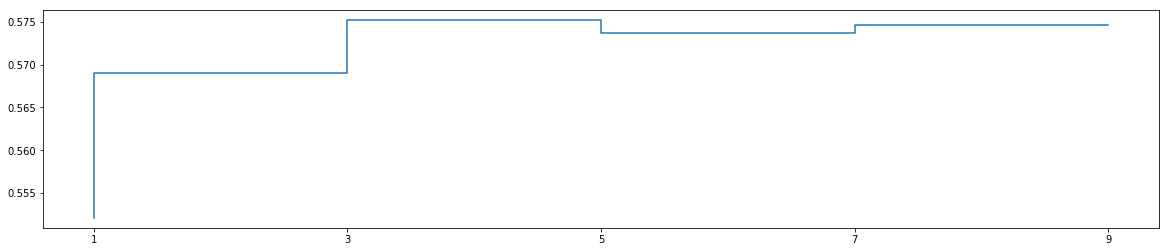

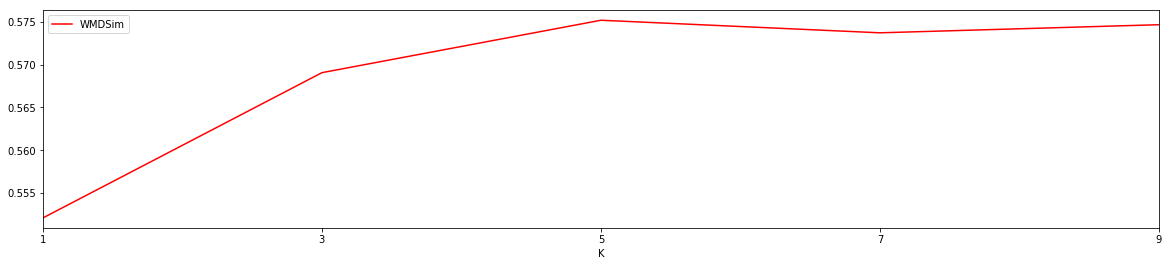

In [54]:
test_metrics.load()
test_metrics.show()

W0706 00:43:11.309253 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 1, Mean WMDSim: 0.6123775677596798, Time: 0:00:07.383342


W0706 00:43:18.080046 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 3, Mean WMDSim: 0.6142801224312111, Time: 0:00:08.607505


W0706 00:43:26.732297 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 5, Mean WMDSim: 0.6164202766777549, Time: 0:00:11.198151


W0706 00:43:38.690738 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 7, Mean WMDSim: 0.6093771150970018, Time: 0:00:13.766120


W0706 00:43:51.788149 140047639689024 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


K: 9, Mean WMDSim: 0.6109393663087005, Time: 0:00:14.281281
Best K: 5



K,WMDSim
5,0.616420
3,0.614280
1,0.612378
9,0.610939
7,0.609377


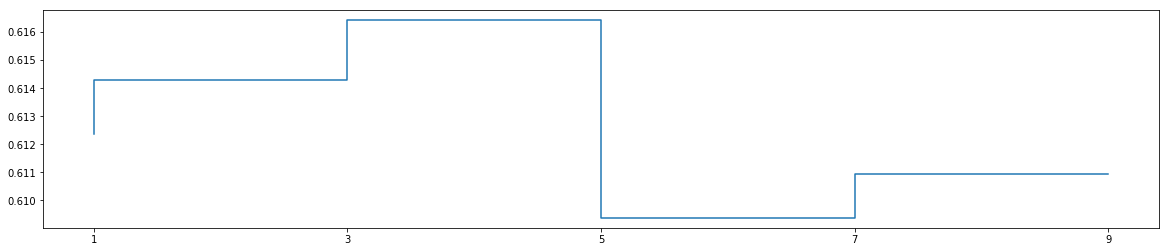

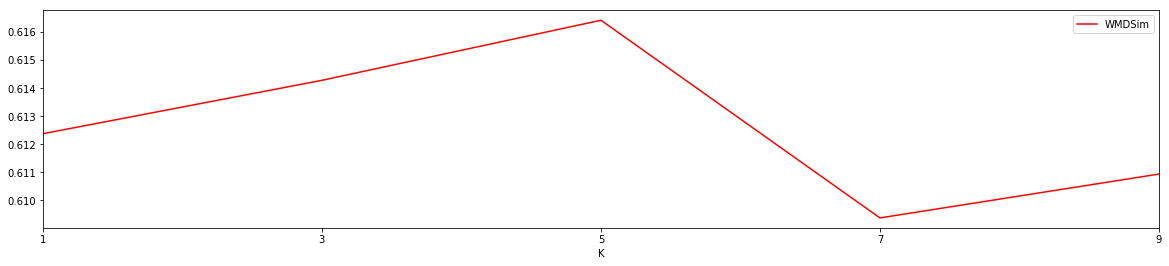

In [55]:
random_train_samples = random_samples(train_samples, 15)
k_values=range(1, 10 + 1, 2)

train_metrics = search_k_finder.find(samples=random_train_samples, k_values=k_values)
train_metrics.show()

## Test model

In [42]:
class TestInspector:
    def __init__(self, k_values):
        self.inspectors = [(k, self.__create_inspector(k=k)) for k in k_values]

    def __create_inspector(self, k):
        return PredictionInspectorFactory.create_inspector(
            model,
            word_to_index,
            index_to_word,
            image_features,
            dataset.descriptions(),
            dataset.max_desc_len(),
            k,
            verbose=False
        )

    def inpect(self, sample):
        for k, inspector in self.inspectors:
            print(f'K={k}')
            inspector.inspect(sample)
        

In [ ]:
test_inspector = TestInspector(k_values=[3])
# test_inspector = TestInspector(k_values=[test_metrics.best_k()])

for sample in random_samples(test_samples, 10):
    test_inspector.inpect(sample)